<a href="https://colab.research.google.com/github/vicente-gonzalez-ruiz/denoising/blob/main/src/denoising/SRA_volume_denoising_opticalflow3d.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Shuffle, Register and Average (SRA) volume denoising

In [1]:
vol_filename = "small_vol.mrc"
from collections import namedtuple
Args = namedtuple("args", ["input", "output"])
fn, fe = vol_filename.split(".")
args = Args(vol_filename , fn + "_denoised." + fe)
print(args)

args(input='small_vol.mrc', output='small_vol_denoised.mrc')


In [2]:
#%pip install gdown

In [3]:
%%bash -s "$args.input"
set -x
OUTPUT_FILENAME=$1
#rm -f $OUTPUT_FILENAME
if test ! -f $OUTPUT_FILENAME ; then
    FILEID="1YDyHWyB1d6yq2LYif2zQcQgr7vhlspYo" # https://drive.google.com/file/d/1YDyHWyB1d6yq2LYif2zQcQgr7vhlspYo/view?usp=sharing
    #FILEID="1iui018SGKa5nb0ybeoUAB7uCUhl9EJ5o" #https://drive.google.com/file/d/1iui018SGKa5nb0ybeoUAB7uCUhl9EJ5o/view?usp=sharing
    #wget --no-check-certificate 'https://docs.google.com/uc?export=download&id='$FILEID -O $OUTPUT_FILENAME #2> /dev/null
    #wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=FILEID' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=FILEID" -O FILENAME && rm -rf /tmp/cookies.txt
    gdown https://drive.google.com/uc?id=$FILEID # pip install gdown
fi
ls -l $OUTPUT_FILENAME
set +x

+ OUTPUT_FILENAME=small_vol.mrc
+ test '!' -f small_vol.mrc
+ ls -l small_vol.mrc


-rw-r----- 1 jupyter-vruiz jupyter-vruiz 8389632 feb 14  2024 small_vol.mrc


+ set +x


In [4]:
# %pip install matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

In [5]:
# %pip install --force-reinstall "information_theory @ git+https://github.com/vicente-gonzalez-ruiz/information_theory"
#%pip install "information_theory @ git+https://github.com/vicente-gonzalez-ruiz/information_theory"

In [6]:
#%pip install cupy-cuda12x # Check the CUDA installed with nvcc --version (that should match with the version provided by nvidia-smi)
#%pip install numba

In [7]:
#%pip install --force-reinstall "motion_estimation @ git+https://github.com/vicente-gonzalez-ruiz/motion_estimation"
#%pip uninstall -y motion_estimation
#%pip install "motion_estimation @ git+https://github.com/vicente-gonzalez-ruiz/motion_estimation"

In [8]:
#%pip install --force-reinstall "optical_flow_3D @ git+https://github.com/vicente-gonzalez-ruiz/optical_flow_3D"
#%pip uninstall -y optical_flow_3D
#%pip install "optical_flow_3D @ git+https://github.com/vicente-gonzalez-ruiz/optical_flow_3D"

In [34]:
import logging
logging.basicConfig(format="[%(filename)s:%(lineno)s %(funcName)s()] %(message)s")
logger = logging.getLogger(__name__)
logger.setLevel(logging.INFO)
logger.setLevel(logging.WARNING)

In [35]:
import motion_estimation._3D.farneback_optical_flow_3D as farneback3D
OF_estimator = farneback3D.OF_Estimation(logger)

In [36]:
import volume.SRA

In [37]:
import motion_estimation._3D.project_optical_flow_3D as project
projector = project.Project(logger)

In [38]:
#%pip install mrcfile
import mrcfile
stack_MRC = mrcfile.open(args.input)
noisy = stack_MRC.data
import numpy as np
noisy = (255*(noisy - np.min(noisy))/(np.max(noisy) - np.min(noisy))).astype(np.uint8)
print(noisy.shape)

(32, 256, 256)


In [39]:
import volume.SRA_optical_flow_3D as SRA
denoiser = SRA.Shuffle_Register_and_Average(OF_estimator, projector, logger, quality_estimator=None, show_image=False)

 iter             min         avg_abs             max        min_flow    avg_abs_flow        max_flow            time
    1           -5.67            1.70            6.53           -5.68            0.45            4.03           26.73
    2           -6.94            1.58            4.92           -3.44            0.46            5.88            1.57
    3           -7.18            1.55            4.49           -3.88            0.46            5.39            1.59
    4           -6.23            1.78            5.97           -3.94            0.47            4.90            1.59
    5           -5.11            1.56            5.82           -3.45            0.47            3.85            1.59
    6           -4.76            1.50            6.06           -4.24            0.47            4.20            1.59
    7           -6.00            1.53            5.33           -3.44            0.47            3.95            1.59
    8           -5.57            1.68            4.82   

In [65]:
denoised = denoiser.filter(
    noisy_volume=noisy,
    N_iters=25,
    std_dev=2.0,
    pyramid_levels=3,
    gauss_size=11,
    iterations=5,
    sigma_k=0.45,
    #filter_type="box", # box | gaussian
    filter_type="gaussian", # box | gaussian
    filter_size=9, # std_dev=2.0
    presmoothing=None
)

Running 3D Farneback optical flow with the following parameters:
Iters: 5 | Levels: 3 | Scale: 0.5 | Kernel: 11 | Filter: gaussian-9 | Presmoothing: None
Running 3D Farneback optical flow with the following parameters:
Iters: 5 | Levels: 3 | Scale: 0.5 | Kernel: 11 | Filter: gaussian-9 | Presmoothing: None
Running 3D Farneback optical flow with the following parameters:
Iters: 5 | Levels: 3 | Scale: 0.5 | Kernel: 11 | Filter: gaussian-9 | Presmoothing: None
Running 3D Farneback optical flow with the following parameters:
Iters: 5 | Levels: 3 | Scale: 0.5 | Kernel: 11 | Filter: gaussian-9 | Presmoothing: None
Running 3D Farneback optical flow with the following parameters:
Iters: 5 | Levels: 3 | Scale: 0.5 | Kernel: 11 | Filter: gaussian-9 | Presmoothing: None
Running 3D Farneback optical flow with the following parameters:
Iters: 5 | Levels: 3 | Scale: 0.5 | Kernel: 11 | Filter: gaussian-9 | Presmoothing: None
Running 3D Farneback optical flow with the following parameters:
Iters: 5 | 

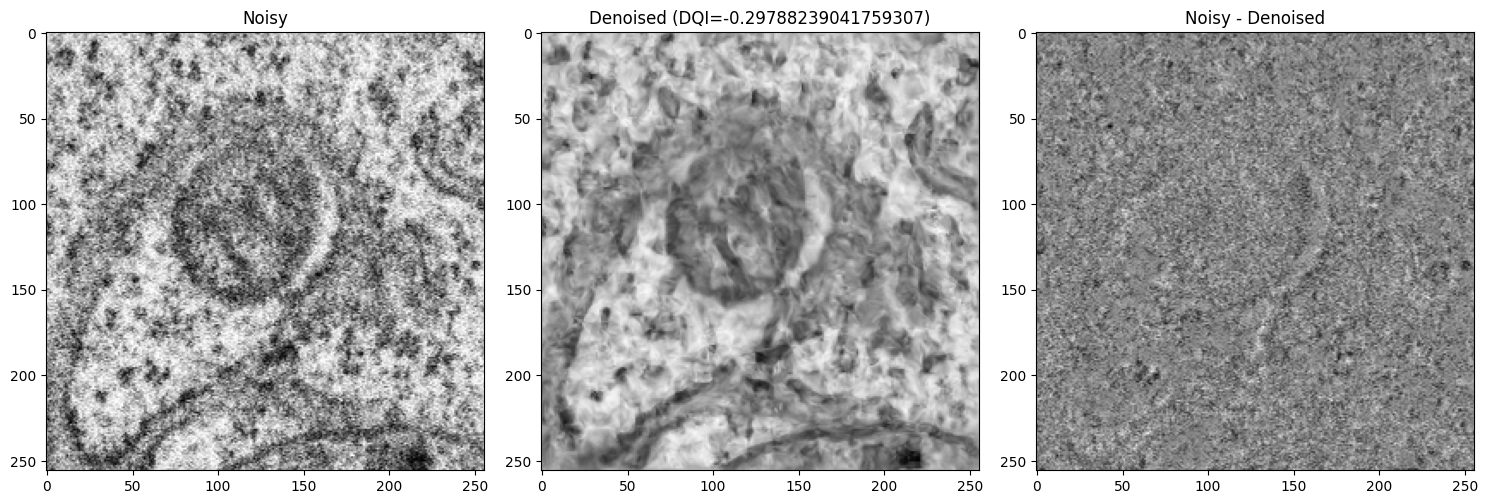

In [67]:
import information_theory
slice_index = noisy.shape[0]//2
fig, axs = plt.subplots(1, 3, figsize=(15, 45))
axs[0].imshow(noisy[16], cmap="gray")
axs[0].set_title(f"Noisy")
axs[1].imshow(denoised[slice_index], cmap="gray")
axs[1].set_title(f"Denoised (DQI={information_theory.information.compute_quality_index(noisy[slice_index], denoised[slice_index])})")
axs[2].imshow(noisy[slice_index] - denoised[slice_index], cmap="gray")
axs[2].set_title(f"Noisy - Denoised")
fig.tight_layout()
plt.show()

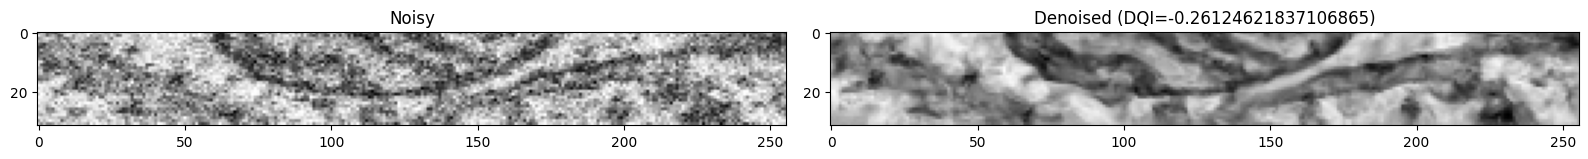

In [68]:
fig, axs = plt.subplots(1, 2, figsize=(16, 32))
slice_idx = noisy.shape[1]//2
axs[0].imshow(noisy[:, slice_idx], cmap="gray")
axs[0].set_title(f"Noisy")
axs[1].imshow(denoised[:, slice_idx], cmap="gray")
axs[1].set_title(f"Denoised (DQI={information_theory.information.compute_quality_index(noisy[:, slice_idx], denoised[:, slice_idx])})")
fig.tight_layout()
plt.show()

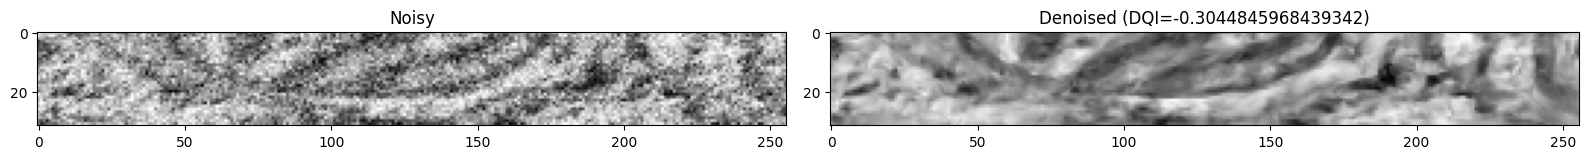

In [69]:
fig, axs = plt.subplots(1, 2, figsize=(16, 32))
slice_idx = noisy.shape[2]//2
axs[0].imshow(noisy[:, :, slice_idx], cmap="gray")
axs[0].set_title(f"Noisy")
axs[1].imshow(denoised[:, :, slice_idx], cmap="gray")
axs[1].set_title(f"Denoised (DQI={information_theory.information.compute_quality_index(noisy[:, :, slice_idx], denoised[:, :, slice_idx])})")
fig.tight_layout()
plt.show()

In [ ]:
with mrcfile.new(f"{fn}_SRA_denoised.mrc", overwrite=True) as mrc:
    mrc.set_data(denoised.astype(np.float32))
    mrc.data

In [ ]:
#import opticalflow3D
#import warnings
#from numba.core.errors import NumbaPerformanceWarning
#warnings.filterwarnings("ignore", category=NumbaPerformanceWarning)
#else:
#    import motion_estimation._3D.farneback as farneback3D

In [ ]:
#%pip install "optical_flow_3D @ git+https://github.com/vicente-gonzalez-ruiz/optical_flow_3D"

In [ ]:
#%pip install --force-reinstall "information_theory @ git+https://github.com/vicente-gonzalez-ruiz/information_theory"
#%pip install "information_theory @ git+https://github.com/vicente-gonzalez-ruiz/information_theory"
#%pip uninstall -y information_theory
import information_theory  # pip install --force-reinstall "information_theory @ git+https://github.com/vicente-gonzalez-ruiz/information_theory"

In [ ]:
if use_opticalflow3D:
    block_size = (noisy.shape[0], noisy.shape[1], noisy.shape[2])

In [ ]:
if use_opticalflow3D:
    #farneback = opticalflow3D.Farneback3D(iters=5, num_levels=3, scale=0.5, spatial_size=33, presmoothing=None, filter_type="gaussian", filter_size=3)
    #farneback = opticalflow3D.Farneback3D(iters=5, num_levels=3, scale=0.5, spatial_size=13, presmoothing=None, filter_type="gaussian", filter_size=7)
    #farneback = opticalflow3D.Farneback3D(iters=5, num_levels=3, scale=0.5, spatial_size=5, presmoothing=3, filter_type="gaussian", filter_size=5)
    #farneback = opticalflow3D.Farneback3D(iters=5, num_levels=3, scale=0.5, spatial_size=3, presmoothing=5, filter_type="box", filter_size=3)
    #farneback = opticalflow3D.Farneback3D(iters=5, num_levels=5, scale=0.5, spatial_size=3, presmoothing=5, filter_type="box", filter_size=3)
    #farneback = opticalflow3D.Farneback3D(iters=5, num_levels=5, scale=0.5, spatial_size=3, presmoothing=5, filter_type="gaussian", filter_size=11)
    #farneback = opticalflow3D.Farneback3D(iters=5, num_levels=1, scale=0.5, spatial_size=5, presmoothing=4, filter_type="box", filter_size=5)
    estimator = opticalflow3D.Farneback3D(iters=5, num_levels=5, scale=0.5, spatial_size=9, sigma_k=0.15, filter_type="gaussian" ,filter_size=7, presmoothing=None, device_id=0)
else:
    estimator = farneback3D(

In [ ]:
RS_sigma = 0.75
if use_opticalflow3D:
    denoised = RSIVD.filter(farneback, block_size, noisy, RS_sigma=RS_sigma, N_iters=20)
else:


In [ ]:
np.min(denoised)

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(16, 32))
axs[0].imshow(noisy[:, 100], cmap="gray")
axs[0].set_title(f"Noisy")
axs[1].imshow(denoised[:, 100], cmap="gray")
axs[1].set_title(f"Denoised (DQI={information_theory.information.compute_quality_index(noisy[:, 100], denoised[:, 100])})")
fig.tight_layout()
plt.show()

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(16, 32))
axs[0].imshow(noisy[:, :, 100], cmap="gray")
axs[0].set_title(f"Noisy")
axs[1].imshow(denoised[:, :, 100], cmap="gray")
axs[1].set_title(f"Denoised (DQI={information_theory.information.compute_quality_index(noisy[:, :, 100], denoised[:, :, 100])})")
fig.tight_layout()
plt.show()

In [ ]:
figure(figsize=(32, 32))
plt.subplot(1, 3, 1)
plt.title("original")
imgplot = plt.imshow(noisy_vol[15][::-1, :], cmap="gray")
plt.subplot(1, 3, 2)
plt.title("$\sigma_\mathrm{RS}=$"+f"{RS_sigma}")
plt.imshow(denoised_vol[15][::-1, :], cmap="gray")
plt.subplot(1, 3, 3)
plt.title("difference")
plt.imshow(noisy_vol[15][::-1, :] - denoised_vol[15][::-1, :], cmap="gray")

In [ ]:
figure(figsize=(32, 32))
plt.subplot(1, 3, 1)
plt.title("original")
imgplot = plt.imshow(noisy_vol[15][::-1, :], cmap="gray")
plt.subplot(1, 3, 2)
plt.title("$\sigma_\mathrm{RS}=$"+f"{RS_sigma}")
plt.imshow(denoised_vol[15][::-1, :], cmap="gray")
plt.subplot(1, 3, 3)
plt.title("difference")
plt.imshow(noisy_vol[15][::-1, :] - denoised_vol[15][::-1, :], cmap="gray")

In [ ]:
skimage.io.imsave(f"{vol_name}_denoised_{RS_sigma}.tif", denoised_vol, imagej=True)

In [ ]:
img = skimage.io.imread("http://www.hpca.ual.es/~vruiz/images/barb.png")#[:256, :256]

In [ ]:
noisy_vol = np.stack([img]*32)

In [ ]:
noisy_vol.shape

In [ ]:
mean = 0
var = 1000
sigma = var**0.5
for i in range(noisy_vol.shape[0]):
    noise = np.random.normal(mean,sigma,img.shape).reshape(img.shape)
    noisy_vol[i] = np.clip(a=img.astype(np.float32) + noise, a_min=0, a_max=255).astype(np.uint8)

In [ ]:
farneback = opticalflow3D.Farneback3D(iters=5,
                                      num_levels=3,
                                      scale=0.5,
                                      spatial_size=5,
                                      presmoothing=2,
                                      filter_type="box",
                                      filter_size=5,
                                     )

In [ ]:
RS_sigma = 1.0
denoised_vol = RSIVD.filter(farneback, block_size, noisy_vol, RS_sigma=RS_sigma, N_iters=30)

In [ ]:
figure(figsize=(32, 32))
plt.subplot(1, 3, 1)
plt.title("original")
imgplot = plt.imshow(noisy_vol[15], cmap="gray")
plt.subplot(1, 3, 2)
plt.title("$\sigma_\mathrm{RS}=$"+f"{RS_sigma}")
plt.imshow(denoised_vol[15], cmap="gray")
plt.subplot(1, 3, 3)
plt.title("difference")
plt.imshow(noisy_vol[15] - denoised_vol[15], cmap="gray")

In [ ]:
RS_sigma = 1.0
denoised_vol = RSIVD.filter(farneback, block_size, noisy_vol, RS_sigma=RS_sigma, N_iters=100)

In [ ]:
figure(figsize=(32, 32))
plt.subplot(1, 3, 1)
plt.title("original")
imgplot = plt.imshow(noisy_vol[15], cmap="gray")
plt.subplot(1, 3, 2)
plt.title("$\sigma_\mathrm{RS}=$"+f"{RS_sigma}")
plt.imshow(denoised_vol[15], cmap="gray")
plt.subplot(1, 3, 3)
plt.title("difference")
plt.imshow(noisy_vol[15] - denoised_vol[15], cmap="gray")

In [ ]:
RS_sigma = 2.0
denoised_vol = RSIVD.filter(farneback, block_size, noisy_vol, RS_sigma=RS_sigma, N_iters=30)

In [ ]:
figure(figsize=(32, 32))
plt.subplot(1, 3, 1)
plt.title("original")
imgplot = plt.imshow(noisy_vol[15], cmap="gray")
plt.subplot(1, 3, 2)
plt.title("$\sigma_\mathrm{RS}=$"+f"{RS_sigma}")
plt.imshow(denoised_vol[15], cmap="gray")
plt.subplot(1, 3, 3)
plt.title("difference")
plt.imshow(noisy_vol[15] - denoised_vol[15], cmap="gray")

In [ ]:
RS_sigma = 3.0
denoised_vol = RSIVD.filter(farneback, block_size, noisy_vol, RS_sigma=RS_sigma, N_iters=30)

In [ ]:
figure(figsize=(32, 32))
plt.subplot(1, 3, 1)
plt.title("original")
imgplot = plt.imshow(noisy_vol[15], cmap="gray")
plt.subplot(1, 3, 2)
plt.title("$\sigma_\mathrm{RS}=$"+f"{RS_sigma}")
plt.imshow(denoised_vol[15], cmap="gray")
plt.subplot(1, 3, 3)
plt.title("difference")
plt.imshow(noisy_vol[15] - denoised_vol[15], cmap="gray")

In [ ]:
#skimage.io.imsave(f"{vol_name}_denoised_{RS_sigma}.tif", denoised_vol, imagej=True)

In [ ]:
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

In [ ]:
if IN_COLAB:
    print("Running in Colab")
    !apt install libcudart11.0
    !apt install libcublas11
    !apt install libcufft10
    !apt install libcusparse11
    !apt install libnvrtc11.2

In [ ]:
if IN_COLAB:
    !pip install cupy-cuda12x
    !pip install opticalflow3D

In [ ]:
#use_opticalflow3D = False

In [ ]:
#%pip install opticalflow3d

In [ ]:
#vol_name = "small_vol"

In [ ]:
if IN_COLAB:
    print("Running in Colab")
    !pip install cupy-cuda12x
    !pip install opticalflow3D
    !apt install libcudart11.0
    !apt install libcublas11
    !apt install libcufft10
    !apt install libcusparse11
    !apt install libnvrtc11.2
    from google.colab import drive
    drive.mount('/content/drive')
    !cp drive/Shareddrives/TomogramDenoising/tomograms/{vol_name}.tif .
else:
    print("Running in locahost")
    !cp ~/Downloads/{vol_name}.tif .